## 1. Searching for oportunities inside HTML files
<br>
<p>It used to take days for financial news to spread via radio, newspapers, and word of mouth. Now, in the age of the internet, it takes seconds. Did you know news articles are <em>automatically</em> being generated from figures and earnings call streams? Hedge funds and independent traders are using data science to process this wealth of information in the quest for profit.</p>
<p>In this notebook, we will generate investing insight by applying <a href="https://en.wikipedia.org/wiki/Sentiment_analysis">sentiment analysis</a> on financial news headlines from <a href="https://finviz.com">FINVIZ.com</a>. Using this <a href="https://en.wikipedia.org/wiki/Natural_language_processing">natural language processing</a> technique, we can understand the emotion behind the headlines and predict whether the market <em>feels</em> good or bad about a stock. It would then be possible to make educated guesses on how certain stocks will perform and trade accordingly. (And hopefully, make money!)</p>
<p><img src="https://assets.datacamp.com/production/project_611/img/fb_headlines.png" alt="Facebook headlines from FINVIZ.com"></p>
<p>Why headlines? And why from FINVIZ?</p>
<ol>
<li>Headlines, which have similar length, are easier to parse and group than full articles, which vary in length.</li>
<li>FINVIZ has a list of trusted websites, and headlines from these sites tend to be more consistent in their jargon than those from independent bloggers. Consistent textual patterns will improve the sentiment analysis.</li>
</ol>
<br>
TSLA:<br>
https://finviz.com/quote.ashx?t=TSLA&ty=c&p=d&b=1

<br><br>
FB:<br>
https://finviz.com/quote.ashx?t=FB&ty=c&p=d&b=1



In [1]:
# Importing libraries

# BeautifulSoup to process text with html tags 
from bs4 import BeautifulSoup
import os
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt


html_tables = {}

# For every table in the datasets folder.
for table_name in os.listdir('datasets'):
    #this is the path to the file.
    table_path = f'datasets/{table_name}'
    # Open as a python file in read-only mode
    table_file = open(table_path, 'r').read()
    # Read the contents of the file into 'html'
    html = BeautifulSoup(table_file, 'html.parser')
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id="news-table")
    # Add the table to our dictionary
    html_tables[table_name] = html_table
    

## 2. Checking headlines grabbed
<p>We've grabbed the table that contains the headlines from each stock's HTML file, but before we start parsing those tables further, we need to understand how the data in that table is structured. We have a few options for this:</p>


In [2]:
# Reading one single day of headlines 
tsla = html_tables['tsla_22sep.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.find_all('tr')


In [3]:
# For each row...
for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.find('a').text
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.find('td').text
    # Print the count
    print(f'File number {i+1}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text)
    print(data_text)
    # The following exits the loop after four rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

File number 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
File number 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
File number 3:
SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
File number 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


## 3. Extracting the news headlines
<p>As we saw above, 
the interesting data inside each table row (<code>&lt;tr&gt;</code>) is in the text inside the <code>&lt;td&gt;</code> and <code>&lt;a&gt;</code> tags. Let's now actually parse the data for <strong>all</strong> tables in a comfortable data structure.</p>

In [4]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() 
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' with the only element
        # If not, load 'date' with the 1st element and 'time' with the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split("_")[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, x.a.text])    

In [5]:
for item in parsed_news[:10]:
    print(item, "\n")

['fb', 'Jan-04-19', '06:22PM', 'Facebook, Apple, Netflix, Amazon and Alphabet Power Friday Gains'] 

['fb', 'Jan-04-19', '05:15PM', 'Earnings Reports for the Week of Jan. 7-11 (BBBY, KBH)'] 

['fb', 'Jan-04-19', '04:55PM', 'COLUMN-Commentary: 2019 will be the year of more state control'] 

['fb', 'Jan-04-19', '04:53PM', '3 Tech Trends to Watch in 2019'] 

['fb', 'Jan-04-19', '04:30PM', "Will Denver's tech growth continue in 2019?"] 

['fb', 'Jan-04-19', '02:46PM', 'Facebook to Prioritize Video in 2019'] 

['fb', 'Jan-04-19', '01:52PM', 'ScotteVest CEO: How a Facebook Passion Project Evolved into a New Business'] 

['fb', 'Jan-04-19', '01:47PM', 'Millennials Load Up on Battered Apple, Facebook, GE'] 

['fb', 'Jan-04-19', '01:00PM', 'FAANGs See a Weak Start to 2019: More Pain Ahead for ETFs?'] 

['fb', 'Jan-04-19', '12:18PM', 'U[PDATE: Netflix shares soar 9% as Goldman adds stock to its Conviction List'] 



## 4. Make NLTK give its results about the headlines
<p>Sentiment analysis is very sensitive to context. As an example, saying <em>"This kills me"</em> often means something positive if the context is a video game you are enjoying with your friends, but it very often means something negative when we are talking about opioids. Remember that the reason we chose headlines is so we can try to extract sentiment from financial journalists, who like most professionals, have their own lingo. Let's now make NLTK think like a financial journalist by adding some new words and sentiment values to our lexicon.</p>

In [6]:
# NLTK VADER for sentiment analysis
nltk.download("stopwords")
nltk.download('vader_lexicon')
# Adding new words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon

vader.lexicon.update(new_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aleon\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 5. BREAKING NEWS: NLTK Crushes Sentiment Estimates
<p>Now that we have the data and the algorithm loaded, we will get to the core of the matter: <br>
    
 Programmatically predicting sentiment out of news headlines! Luckily for us, VADER is very high level so, in this case, we will not adjust the model further<sup>*</sup> other than the lexicon additions from before.</p>
<p><sup>*</sup>VADER "out-of-the-box" with some extra lexicon would likely translate into <strong>heavy losses</strong> with real money. A real sentiment analysis tool with chances of being profitable will require a very extensive and dedicated to finance news lexicon. Furthermore, it might also not be enough using a pre-packaged model like VADER.</p>

In [26]:
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(item) for item in scored_news['headline']]
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames
scored_news = scored_news.join(scores_df)
# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,fb,2019-01-04,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",0.0,0.631,0.369,0.4767
1,fb,2019-01-04,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,0.0,1.000,0.000,0.0000
2,fb,2019-01-04,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,0.0,1.000,0.000,0.0000
3,fb,2019-01-04,04:53PM,3 Tech Trends to Watch in 2019,0.0,1.000,0.000,0.0000
4,fb,2019-01-04,04:30PM,Will Denver's tech growth continue in 2019?,0.0,0.698,0.302,0.3818


## 6. Plot all the sentiment in subplots
<p>Now that we have the scores, let's start plotting the results. We will start by plotting the time series for the stocks we have.</p>

In [64]:
# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date','ticker']).mean()
# Unstack the column ticker
mean_c = mean_c.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis='columns')
mean_c.head()

ticker,fb,tsla
date,,
2018-09-18,-0.052564,-0.085650
2018-09-19,0.057568,-0.025949
2018-09-20,0.018447,0.148757
2018-09-21,0.014310,-0.049575
2018-09-22,0.255300,NaN


In [67]:
plt.style.use('seaborn-dark-palette')
%matplotlib inline
# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date','ticker']).mean()

#Unstack the column ticker
mean_c = mean_c.unstack()
mean_c
# # Get the cross-section of compound in the 'columns' axis
# mean_c = mean_c.xs('compound', axis='columns')
# # Plot a bar chart with pandas

# mean_c.plot(kind='bar', figsize=(16,12))

neg                 neu                 pos            \
ticker            fb      tsla        fb      tsla        fb      tsla   
date                                                                     
2018-09-18  0.104864  0.112875  0.843682  0.807688  0.051455  0.079437   
2018-09-19  0.072920  0.066366  0.805560  0.879610  0.121640  0.054000   
2018-09-20  0.059567  0.067304  0.870233  0.762609  0.070200  0.170087   
2018-09-21  0.052762  0.102800  0.886381  0.818600  0.060857  0.078600   
2018-09-22  0.000000       NaN  0.899000       NaN  0.101000       NaN   
2018-11-16       NaN  0.022000       NaN  0.931810       NaN  0.046190   
2018-11-17       NaN  0.000000       NaN  0.916500       NaN  0.083500   
2018-11-18       NaN  0.000000       NaN  0.956667       NaN  0.043333   
2018-11-19       NaN  0.093263       NaN  0.821105       NaN  0.085632   
2018-11-20       NaN  0.014154       NaN  0.941308       NaN  0.044538   
2018-11-21       NaN  0.056091       NaN  0.821273       NaN  0.122636   
2018-11-22       NaN  0.370000       NaN  0.630000       NaN  0.000000   
2018-11-23       NaN  0.040000       NaN  0.920000       NaN  0.040000   
2018-11-25       NaN  0.052750       NaN  0.801500       NaN  0.145750   
2018-11-26       NaN  0.107833       NaN  0.828111       NaN  0.064056   
2018-12-28  0.146909       NaN  0.816273       NaN  0.036818       NaN   
2018-12-29  0.102333       NaN  0.836333       NaN  0.061333       NaN   
2018-12-30  0.033667       NaN  0.817167       NaN  0.149167       NaN   
2018-12-31  0.152267       NaN  0.760000       NaN  0.087800       NaN   
2019-01-01  0.000000       NaN  0.791667       NaN  0.208333       NaN   
2019-01-02  0.023857  0.183714  0.882762  0.717449  0.093381  0.098918   
2019-01-03  0.089250  0.142045  0.817700  0.826682  0.093050  0.031273   
2019-01-04  0.066524  0.031034  0.858286  0.899345  0.075190  0.069621   

            compound            
ticker            fb      tsla  
date                            
2018-09-18 -0.052564 -0.085650  
2018-09-19  0.057568 -0.025949  
2018-09-20  0.018447  0.148757  
2018-09-21  0.014310 -0.049575  
2018-09-22  0.255300       NaN  
2018-11-16       NaN  0.026714  
2018-11-17       NaN  0.190900  
2018-11-18       NaN  0.067433  
2018-11-19       NaN  0.002384  
2018-11-20       NaN  0.066862  
2018-11-21       NaN  0.162045  
2018-11-22       NaN -0.637260  
2018-11-23       NaN  0.000000  
2018-11-25       NaN  0.046725  
2018-11-26       NaN -0.103317  
2018-12-28 -0.120973       NaN  
2018-12-29 -0.024933       NaN  
2018-12-30  0.173817       NaN  
2018-12-31 -0.076540       NaN  
2019-01-01  0.291667       NaN  
2019-01-02  0.080748 -0.095986  
2019-01-03  0.045855 -0.131786  
2019-01-04  0.015771  0.060776

In [49]:
# Checking what happened on 2018-11-22
from IPython.display import display
pd.set_option('display.max_colwidth', 100)
scored_news['date'] = pd.to_datetime(scored_news['date'], format='%Y-%m-%d')
check_duplicates = scored_news.loc[scored_news['date'] == '2018-11-22']
check_duplicates.headline[:]

426        Tesla Cuts China Car Prices: Can Others Survive Tariff Heat?
427                  [$$] Tesla cuts prices in China as trade war bites
428        Tesla Lowers Car Prices in China After Trade War Hits Demand
429    Tesla cuts China car prices to absorb hit from trade war tariffs
430    Tesla cuts China car prices to absorb hit from trade war tariffs
Name: headline, dtype: object

## 7. Weekends and duplicates
<p>What happened to Tesla on November 22nd? Since we happen to have the headlines inside our <code>DataFrame</code>, a quick peek reveals that there are a few problems with that particular day: </p>
<ul>
<li>There are only 5 headlines for that day.</li>
<li>Two headlines are verbatim the same as another but from another news outlet.</li>
</ul>
<p>Let's clean up the dataset a bit, but not too much! While some headlines are the same news piece from different sources, the fact that they are written differently could provide different perspectives on the same story. Plus, when one piece of news is more important, it tends to get more headlines from multiple sources. What we want to get rid of is verbatim copied headlines, as these are very likely coming from the same journalist and are just being "forwarded" around, so to speak.</p>

In [50]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(['ticker','headline'],keep= 'first')
# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean.headline.count()
# Print before and after numbers to get an idea of how we did 
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

In [74]:
scored_news_clean[scored_news_clean['date'] == '2018-11-22']

,ticker,date,time,headline,neg,neu,pos,compound
426,tsla,2018-11-22,08:23AM,Tesla Cuts China Car Prices: Can Others Survive Tariff Heat?,0.196,0.804,0.0,-0.2960
427,tsla,2018-11-22,03:55AM,[$$] Tesla cuts prices in China as trade war bites,0.433,0.567,0.0,-0.7269
428,tsla,2018-11-22,01:24AM,Tesla Lowers Car Prices in China After Trade War Hits Demand,0.463,0.537,0.0,-0.7096
429,tsla,2018-11-22,01:02AM,Tesla cuts China car prices to absorb hit from trade war tariffs,0.379,0.621,0.0,-0.7269


<AxesSubplot:xlabel='date'>

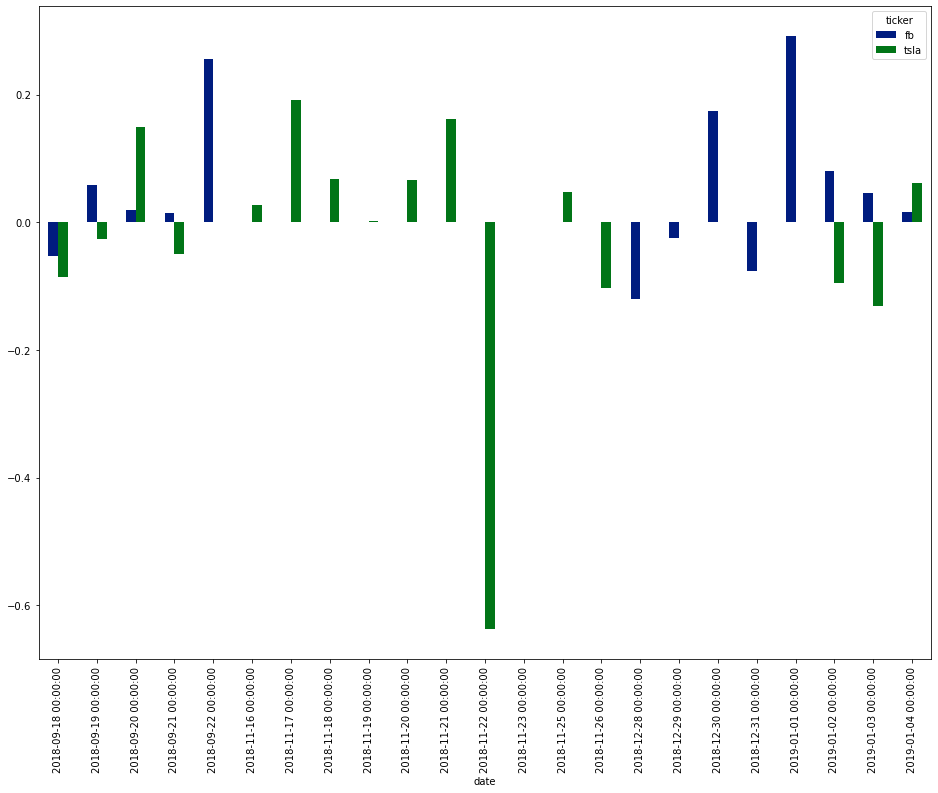

In [70]:
# Group by date and ticker columns from scored_news and calculate the mean
mean_cleaned = scored_news_clean.groupby(['date','ticker']).mean()

# # Unstack the column ticker
mean_cleaned = mean_cleaned.unstack()
mean_cleaned
# # Get the cross-section of compound in the 'columns' axis
mean_cleaned = mean_c.xs('compound', axis='columns')
# # Plot a bar chart with pandas

mean_cleaned.plot(kind='bar', figsize=(16,12))

## 8. Sentiment on one single trading day and stock
<p>Just to understand the possibilities of this dataset and get a better feel of the data, let's focus on one trading day and one single stock. We will make an informative plot where we will see the smallest grain possible: headline and subscores.</p>

In [73]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section the fb row
single_day = single_day.xs('fb', axis='rows')
# Select the 3rd of January of 2019
single_day = single_day.loc['2019-01-03']
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# Set the index to time and 
single_day = single_day.set_index('time')
# Sort it
single_day = single_day.sort_index()
single_day

,headline,neg,neu,pos,compound
time,,,,,
06:00:00,Why Internet Censorship Doesnt Work and Never Will,0.000,1.000,0.000,0.0000
08:04:00,"3 Big Stock Charts for Thursday: Medtronic, Facebook and eBay",0.000,1.000,0.000,0.0000
09:07:00,"The Zacks Analyst Blog Highlights: Facebook, Wells Fargo, AT&T, Intel and Glaxo",0.000,0.846,0.154,0.2500
09:12:00,Why The FAANGs Are Crucial To A 2019 Market Rally,0.000,1.000,0.000,0.0000
09:34:00,Apple warning stoking fears of slowdown in Chinese econom...,0.426,0.574,0.000,-0.6369
09:48:00,"Stock Market News For Jan 3, 2019",0.000,1.000,0.000,0.0000
09:58:00,Facebook Falls 3%,0.981,0.019,0.000,-0.9993
10:08:00,Mark Zuckerberg Halts Stock Sales as Facebook Shares Tumble,0.000,0.784,0.216,0.2960
10:21:00,Facebook Under Fire for Collecting Data From Android Apps,0.231,0.769,0.000,-0.3400


## 9. Visualize the single day
<p>We will make a plot to visualize the positive, negative and neutral scores for a single day of trading and a single stock. This is just one of the many ways to visualize this dataset.</p>

In [82]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section the fb row
single_day = single_day.xs('fb', axis='rows')
# Select the 3rd of January of 2019
single_day = single_day.loc['2019-01-03']
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# Set the index to time and 
single_day = single_day.set_index('time')
# Sort it
single_day = single_day.sort_index()
single_day.head()

,headline,neg,neu,pos,compound
time,,,,,
06:00:00,Why Internet Censorship Doesnt Work and Never Will,0.000,1.000,0.000,0.0000
08:04:00,"3 Big Stock Charts for Thursday: Medtronic, Facebook and eBay",0.000,1.000,0.000,0.0000
09:07:00,"The Zacks Analyst Blog Highlights: Facebook, Wells Fargo, AT&T, Intel and Glaxo",0.000,0.846,0.154,0.2500
09:12:00,Why The FAANGs Are Crucial To A 2019 Market Rally,0.000,1.000,0.000,0.0000
09:34:00,Apple warning stoking fears of slowdown in Chinese econom...,0.426,0.574,0.000,-0.6369


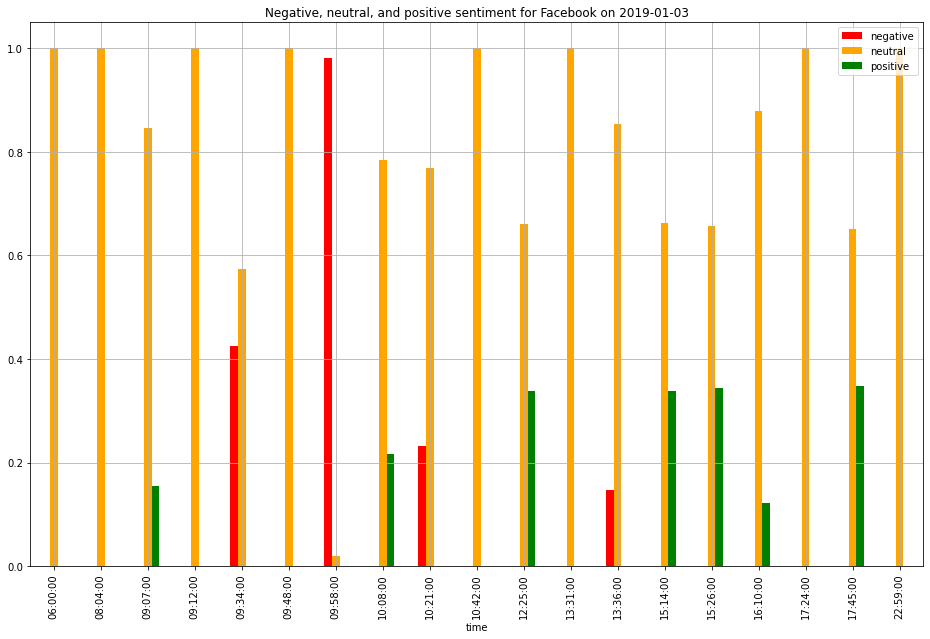

In [91]:
TITLE = "Negative, neutral, and positive sentiment for Facebook on 2019-01-03"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['headline','compound'], axis=1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral',  'positive']
# Plot a stacked bar chart
plot_day.plot(kind='bar', color=COLORS, figsize=(16,10))
plt.title(TITLE)
plt.grid()